# Vision
This is a dev file for the vision module

### 1- Importing necessary librairies

In [250]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Vision.CamCalib as cb
import Vision.EnvTracker as tracker
import importlib
importlib.reload(cb)
importlib.reload(tracker)
import matplotlib.colors as colors
import math

### 2- Camera Calibration (Removing distortions)
Based on this OpenCV [tutorial](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html) 

i. Using the CamCalib object, take some pictures with the chessboard pattern if not already done

In [9]:
cam_stream = cv2.VideoCapture(0)
cam_stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam_stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

calib = cb.CamCalib(cam_stream, (9,6))
calib.take_pictures()

cam_stream.release()

In [211]:
tag = cv2.aruco.generateImageMarker(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), 6, 100)
cv2.imwrite('ArucoTags/m6.png', tag)

True

ii. Use the calibrate function to extract camera parameters and save them in a numpy .npz file to load them later

(-0.5, 999.5, 699.5, -0.5)

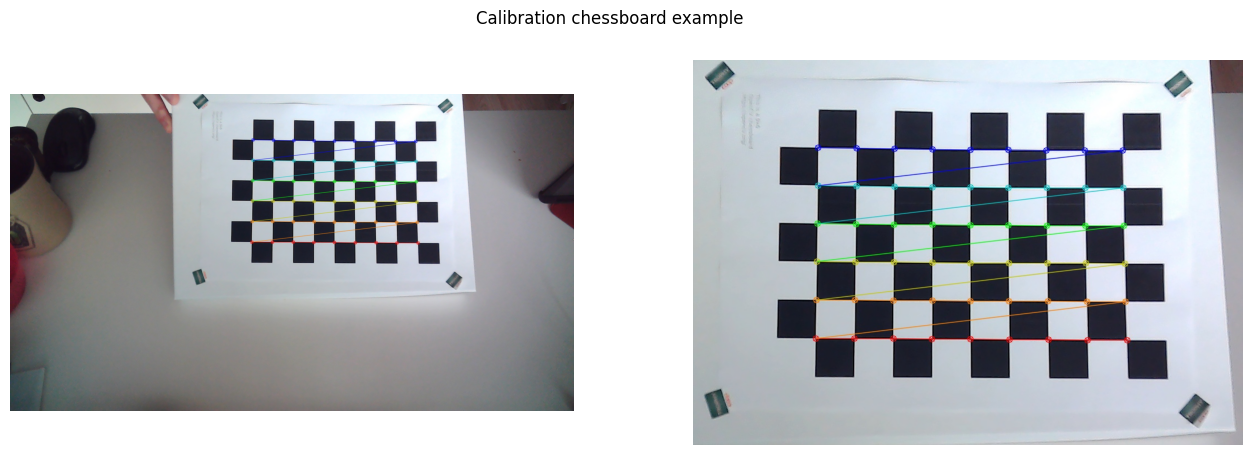

In [327]:
calib = cb.CamCalib(None, (9,6))
#calib.calibrate(25)

# Show example
fig, ax = plt.subplots(1,2)
fig.suptitle('Calibration chessboard example')
fig.set_size_inches(16,5)
im1 = cv2.imread('Vision/images/cal/marked_4.jpg')
ax[0].imshow(im1[:,:,::-1])
ax[0].axis('off')
ax[1].imshow(im1[:700,600:1600,::-1])
ax[1].axis('off')


As one can see, OpenCV detects intersection between black squares. Knowing the size of each square (here 25 mm), it can deduce a mapping from object points to image points. Thus, having multiple viewpoints create a set of equations taht are used to find the parameters that minimizes the re-projection error. This calibration is crucial to straighten the lines of the image and to retrieve camera matrix and distorsions parameters. Knowing all of that allows to estimate accurately distances of objects in image!

iv. Apply the correction to the image

(37, 16, 1860, 1035)


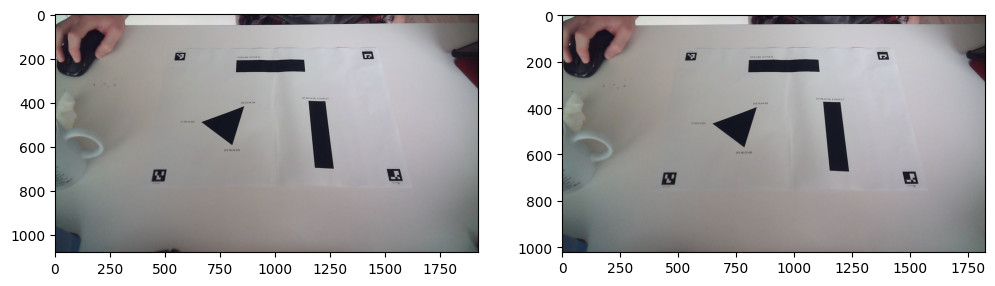

In [328]:
MAP_FILE = "Vision/images/TEST_MAP.jpg"
# Load parameters
cam_mat, dist_coefs, rvecs, tvecs = calib.load_camera_params()

test_img = cv2.imread(MAP_FILE)
# Get optimal camera matrix to keep img dimension the same
h, w = test_img.shape[:2]
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_coefs, (w,h), 1, (w,h), 0)
print(roi)
x,y,w,h = roi

# Using remapping
mapx, mapy = cv2.initUndistortRectifyMap(cam_mat, dist_coefs, None, new_cam_mat, (w,h), 5)
test_img_corr = cv2.remap(test_img, mapx, mapy, cv2.INTER_LINEAR)
#cv2.line(test_img_corr, (750+x,0), (750+x,1080), [255,0,0], 2)
#cv2.line(test_img, (750,0), (750,1080), [255,0,0], 2)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,4)
axs[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

#test_img_corr = cv2.undistort(test_img, cam_mat, dist_coefs, None, new_cam_mat)
axs[1].imshow(test_img_corr[y:y+h,x:x+w,::-1])


### 3- Marker pose detection
i. Prepare environment (load calib data)

In [329]:
calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = calib.load_camera_params()
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_coefs, (1920,1080), 1, (1920,1080), 0)

ii. Identify aruco markers in camera feed

[[11.34010735]
 [ 4.16778369]
 [30.79894045]]
[[11.3421178]
 [-8.1867326]
 [39.0778301]]
[[-9.82780332]
 [ 4.24511205]
 [30.69438822]]
[[-10.0518226 ]
 [ -8.09497653]
 [ 39.0224592 ]]


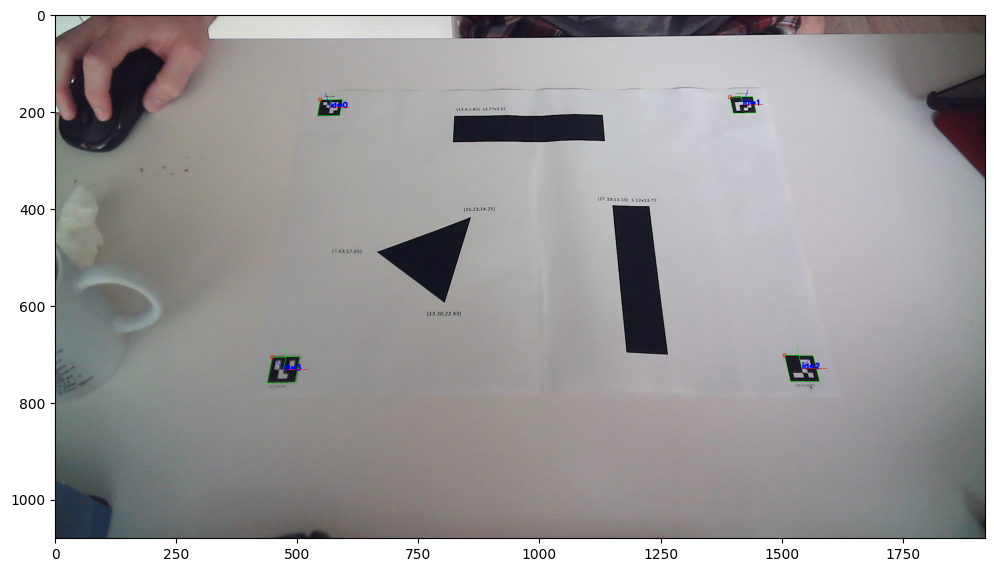

In [330]:
ORIGIN_ID = 1
MARKER_SIZE = 1.15
detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
img_dectect = cv2.copyTo(test_img, None)
corners, ids, rejected = detector.detectMarkers(img_dectect)
img_detection = cv2.aruco.drawDetectedMarkers(img_dectect, corners, ids)
# Create corner points
obj_points = cv2.Mat(np.array([[-MARKER_SIZE/2, MARKER_SIZE/2, 0], 
                        [MARKER_SIZE/2, MARKER_SIZE/2, 0], 
                        [MARKER_SIZE/2, -MARKER_SIZE/2, 0], 
                        [-MARKER_SIZE/2, -MARKER_SIZE/2, 0]]))


for c in corners:
    ret, rvec, tvec = cv2.solvePnP(obj_points, c, cam_mat, dist_coefs)
    print(tvec)
    img_detection = cv2.drawFrameAxes(img_detection, cam_mat, dist_coefs, rvec, tvec, 1, 1)


fig = plt.figure(figsize=(12,8))
plt.imshow(img_detection[:,:,::-1])

ii. Find position and orientation of markers

[ 465  178 1107  566]


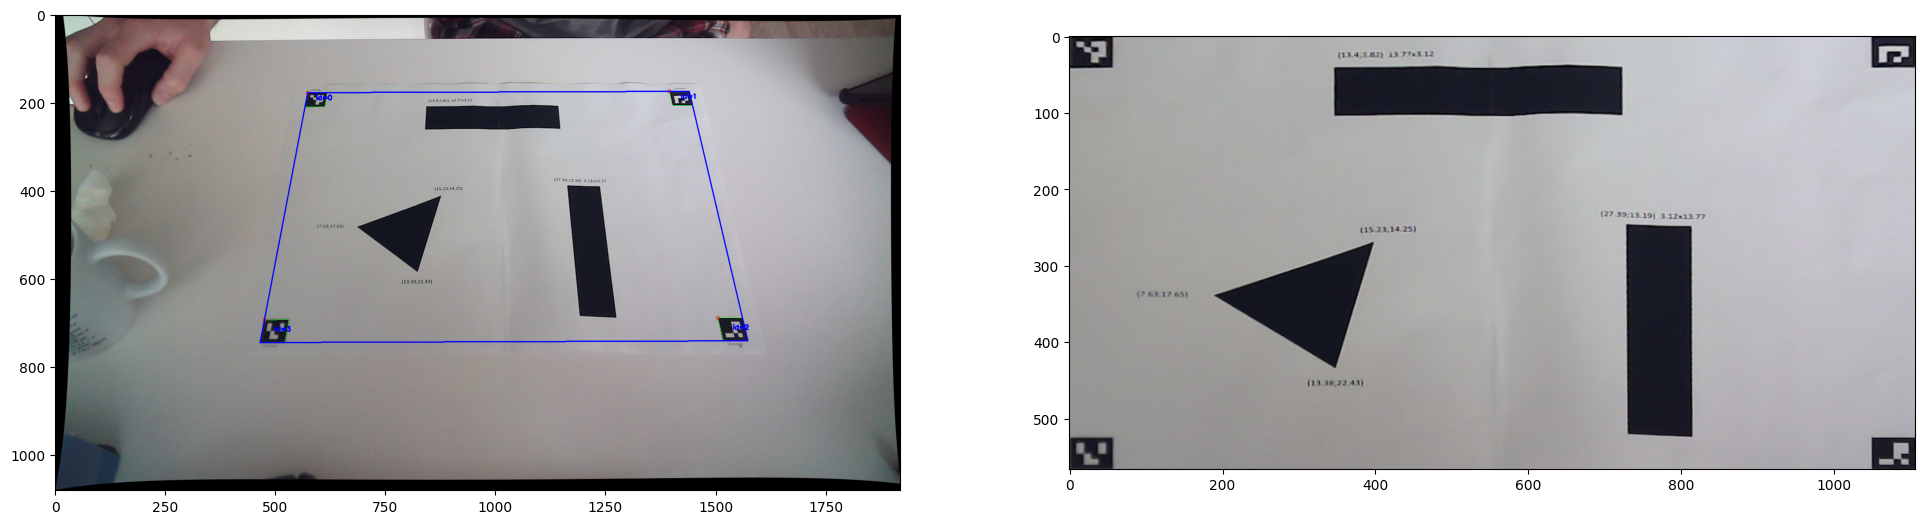

In [333]:
# Draw map limits
img_borders = cv2.imread(MAP_FILE)
#Undistort the image
USE_UNDISTORT = True
if USE_UNDISTORT:
    w,h = img_borders.shape[0:2][::-1]
    mapx, mapy = cv2.initUndistortRectifyMap(cam_mat, dist_coefs, None, new_cam_mat, (w,h), 5)
    img_borders = cv2.remap(img_borders, mapx, mapy, cv2.INTER_LINEAR)
    MARKER_SIZE = 1.15
    detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
    img_dectect = cv2.copyTo(img_borders, None)
    corners, ids, rejected = detector.detectMarkers(img_dectect)
    img_detection = cv2.aruco.drawDetectedMarkers(img_dectect, corners, ids)
else:
    img_detection = img_borders
map_img = cv2.copyTo(img_borders, None)
order_id = (3,0,1,2)
corner_num = (3,0,1,2)
roi_points = []
for i in range(len(order_id)):
    corner_index = np.argwhere(ids[:,0] == order_id[i])[0,0]
    next_corner = np.argwhere(ids[:,0] == order_id[(i+1)%len(ids)])[0,0]
    p1 = np.array([corners[corner_index][0][corner_num[i],0], corners[corner_index][0][corner_num[i],1]], dtype=int)
    p2 = np.array([corners[next_corner][0][corner_num[(i+1)%len(corner_num)],0], corners[next_corner][0][corner_num[(i+1)%len(corner_num)],1]], dtype=int)
    roi_points.append(p1)
    cv2.line(img_detection,p1.astype(int), p2.astype(int), [255,0,0], 2)

p_mid_down = (roi_points[3] + roi_points[0])/2
p_mid_up = (roi_points[2] + roi_points[1])/2
roi_map = np.array([roi_points[0][0], roi_points[1][1], roi_points[3][0]-roi_points[0][0], p_mid_down[1] - p_mid_up[1]], dtype=int)
#ret, rvec, tvec = cv2.solvePnP((0,0), roi_points[0], cam_mat, dist_coefs)

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_detection[:,:,::-1])

print(roi_map)
x,y,w,h = roi_map
m_perspective = cv2.getPerspectiveTransform(np.float32(roi_points), np.float32([[0,h],[0,0],[w,0],[w,h]]))
map_img = cv2.warpPerspective(map_img, m_perspective, (w,h))
#cv2.line(map_img, (0,110), (1100, 110), color=[0,0,255], thickness=2)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(map_img[:,:,::-1])



Edges detection (keeping ROI delimited by markers)

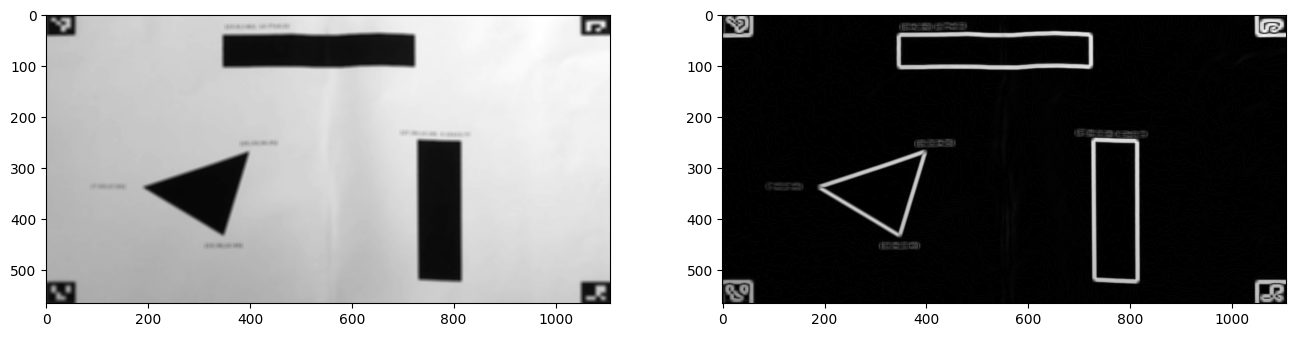

In [254]:
# Using the re-projected map from last step
#img = cv2.imread(MAP_FILE, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(map_img, cv2.COLOR_BGR2GRAY)
img_filtered = cv2.GaussianBlur(img, (9,9), 6)


fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_filtered, cmap='gray')

sobx = cv2.Sobel(img_filtered, cv2.CV_64F, 1, 0, 3)
soby = cv2.Sobel(img_filtered, cv2.CV_64F, 0, 1, 3)
sob = np.sqrt(sobx**2 + soby**2)
sob = (sob * 255 / sob.max()).astype(np.uint8)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sob, cmap='gray')




Having all of the edges, compute the grid and fill it accordingly

In [275]:
def configure_ax(ax, max_x, max_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    MAJOR = 10
    MINOR = 1
    
    major_ticks_x = np.arange(0, max_x+1, MAJOR)
    minor_ticks_x = np.arange(0, max_x+1, MINOR)
    major_ticks_y = np.arange(0, max_y+1, MAJOR)
    minor_ticks_y = np.arange(0, max_y+1, MINOR)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_y])
    ax.set_xlim([-1,max_x])
    ax.grid(True)

    return ax

The grid map is defined as follow:  (195, 130)
Pixels per grid cell: 5.676923076923077 x 4.3538461538461535


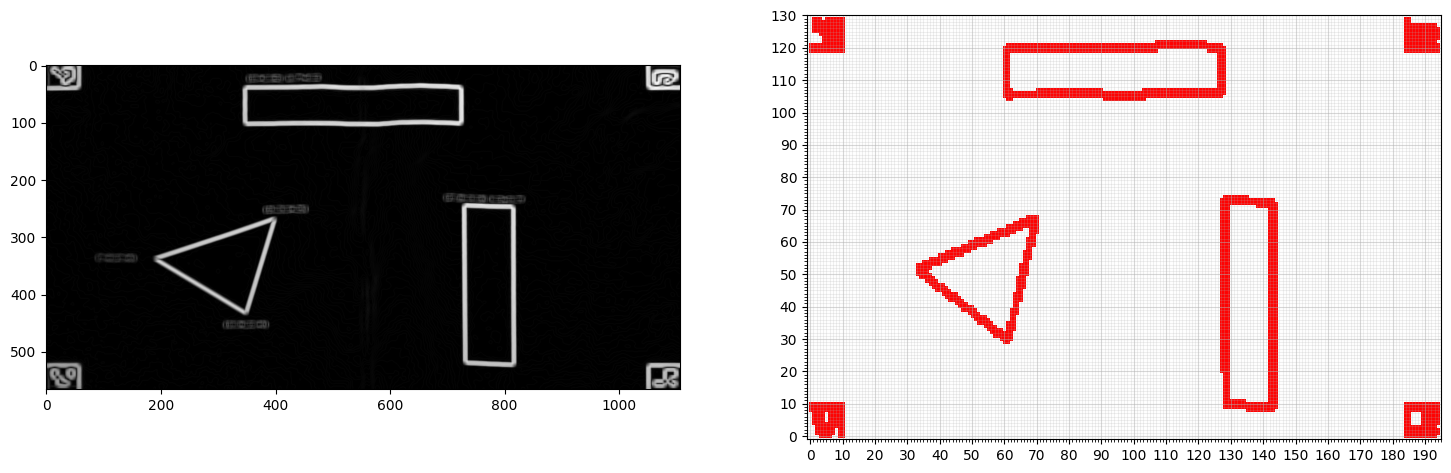

In [287]:
# Real map corners
MAP_W, MAP_H = 39,26  # In centimeters
CORNERS_REAL_POS = np.array([[0,0], [0,MAP_H], [MAP_W, MAP_H], [MAP_W,0]])
RES = 5 # Number of cells per centimeter
THRESHOLD = 100 # 0-255 for pixel intensity

#Initialize the grid
grid_map = np.zeros(((int)(RES*MAP_W), (int)(RES*MAP_H)))
print("The grid map is defined as follow: ", grid_map.shape)

# Find grid shape in pixel space
img_edges = cv2.copyTo(sob, None)
h,w = img_edges.shape
grid_w, grid_h = w/(RES*MAP_W), h/(RES*MAP_H)
print(f'Pixels per grid cell: {grid_w} x {grid_h}')

# Compute obstacles positions (OLD)
#for i in range(len(grid_map)):
#    for j in range(len(grid_map[0])):
#        p_x = math.floor(i*grid_w)
#        p_x_1 = min(math.ceil(i*grid_w + grid_w), w)
#        p_y = math.floor((len(grid_map[0])-1-j)*grid_h)
#        p_y_1 = min(math.ceil((len(grid_map[0])-1-j)*grid_h + grid_h),h)
#        grid_map[i,j] = np.mean(img_edges[p_y:p_y_1,p_x:p_x_1]) > THRESHOLD

# Applying threshold to get binary and measuring average and sum of cells in pixel space
cv2.threshold(img_edges, THRESHOLD, 255, cv2.THRESH_BINARY, img_edges)
for i in range(len(grid_map)):
    for j in range(len(grid_map[0])):
        c_x = math.floor(i*grid_w) + grid_w/2
        c_y = math.floor((len(grid_map[0])-1-j)*grid_h) + grid_h/2
        im_rect = cv2.getRectSubPix(img_edges, ((int) (round(grid_w, 0)),(int) (round(grid_h,0))), (c_x,c_y))
        grid_map[i,j] = cv2.sumElems(im_rect)[0] > cv2.mean(im_rect)[0]


# Show the grid
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(1,2,2)
ax = configure_ax(ax, grid_map.shape[0], grid_map.shape[1])
cmap = colors.ListedColormap(['white', 'red'])
ax.imshow(grid_map.transpose(), cmap=cmap, origin='lower')
ax = fig.add_subplot(1,2,1)
ax.imshow(sob, cmap='gray')


Objects/Contour/Shape extraction using moments

(See OpenCV [tutorial](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html))

In [124]:
img = cv2.imread("images/calibration_test.jpg", cv2.IMREAD_GRAYSCALE)

ret, thres = cv2.threshold(sob, 90, 255, cv2.THRESH_BINARY)
contours, hier = cv2.findContours(thres, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(thres, cmap='gray')



error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


## **Pose estimation of the Thymio**

1. Open camera live feed

In [157]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
cam.set(cv2.CAP_PROP_FRAME_COUNT, 30)
cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

# Read saved cam parameters
cam_calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()

# Other parameters
index = 0

if not cam.isOpened():
    print("Error :: Could not open the camera feed!")

while (True):

    ret, frame = cam.read()

    if not ret:
        print("Error :: Impossible to get image from cam!")
        break

    img_markers = detectMarkersAndPose(frame, cam_mat, dist_coefs)
    cv2.imshow("Robot Tracking", img_markers)

    key = cv2.waitKey(30)
    if key == ord('q'):
        break
    elif key == ord('s'):
        cv2.imwrite(f'images/saved_pict_{index}.jpg', frame)
        index += 1

cam.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

Estimated thymio pose:  [29.46061771  9.55012412]
Estimated angle: 117.59


(-0.5, 1919.5, 1079.5, -0.5)

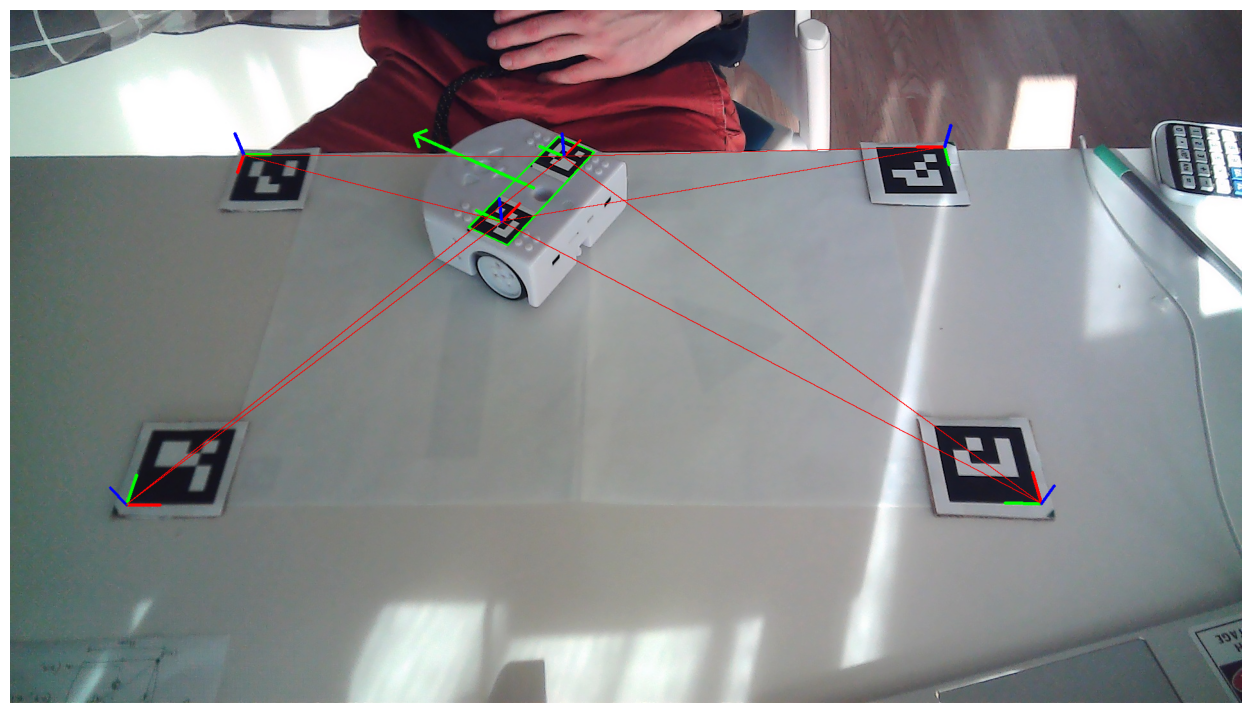

In [324]:
# For debugging/testing, use saved image
importlib.reload(tracker)
cam_calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()
thymio = cv2.imread('Vision/images/saved_pict_1.jpg', cv2.IMREAD_COLOR)
env_tracker = tracker.EnvTracker((42+2*5,30), cam_mat, dist_coefs)
ret, img_markers = env_tracker.detectMarkers(thymio)
map_detected, img_markers = env_tracker.detectMap(thymio)
goal_detected, img_markers = env_tracker.detectGoal(thymio)
thymio_detected, img_markers = env_tracker.detectThymio(thymio)
ret, thymio_pose, thymio_angle, img_markers = env_tracker.thymioPose(img_markers)
print("Estimated thymio pose: ", thymio_pose)
print("Estimated angle: %.2f" % (thymio_angle*180/np.pi))
#img_markers = detectMarkersAndPose(thymio, cam_mat, dist_coefs)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.imshow(img_markers[:,:,::-1])
ax.axis('off')

2. Detect markers and orientation

In [246]:
def detectMarkersAndPose(frame, cam_mtx, dist_coeffs, marker_size=3, marker_dist=10) -> cv2.Mat:
    
    detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
    img_detect = cv2.copyTo(frame, None)
    corners, ids, rejected = detector.detectMarkers(img_detect)
    img_detect = cv2.aruco.drawDetectedMarkers(img_detect, corners, ids)
    # Create corner points
    obj_points = cv2.Mat(np.array([[-marker_dist/2, marker_size/2, 0], 
                            [marker_dist/2, marker_size/2, 0], 
                            [marker_dist/2, -marker_size/2, 0], 
                            [-marker_dist/2, -marker_size/2, 0]]))

    rvecs, tvecs = [], []

    THYMIO_MARKER_IDS = (4,5)
    new_thymio_corners = np.zeros((4,2))
    ids = np.reshape(ids, -1)
    thymio_detected = False
    # Check if thymio markers were found in image
    if np.all(np.isin(THYMIO_MARKER_IDS, ids)):
        thymio_detected = True
        indices = np.where(np.isin(ids, THYMIO_MARKER_IDS))[0]
        for i in indices:
            if ids[i] == THYMIO_MARKER_IDS[0]:
                # Found marker 4
                new_thymio_corners[0,:] = corners[i][0][0,:]
                new_thymio_corners[3,:] = corners[i][0][3,:]
            else:
                # Found marker 5
                new_thymio_corners[1,:] = corners[i][0][1,:]
                new_thymio_corners[2,:] = corners[i][0][2,:]

        # Compute transformation vectors & rotation matrix
        ret, rvec_thymio, tvec_thymio = cv2.solvePnP(obj_points, new_thymio_corners, cam_mtx, dist_coefs)
        img_detect = cv2.drawFrameAxes(img_detect, cam_mtx, dist_coefs, rvec_thymio, tvec_thymio, 2, 4)

        # Draw the heading of the thymio (big arrow pointing forward)
        v_thymio = np.array([[0,0,0], [0,10,0]], dtype=float)
        v_pixels, _ = cv2.projectPoints(v_thymio, rvec_thymio, tvec_thymio, cam_mtx, dist_coeffs)
        cv2.arrowedLine(img_detect, v_pixels[0][0].astype(int), v_pixels[1][0].astype(int), [0,255,0], 3)

    # Check if map is detected and compute origin pose
    MAP_MARKER_IDS = (0,1,2,3)
    MAP_WIDTH, MAP_HEIGHT = (42+2*5,30)
    MAP_MARKER_SIZE = 5 # in cm
    new_map_corners = np.zeros((4,2))
    thymio_pose_estimation = np.zeros((4,3))
    # Check if thymio markers were found in image
    if np.all(np.isin(MAP_MARKER_IDS, ids)):
        indices = np.where(np.isin(ids, MAP_MARKER_IDS))[0]
        # Create map object points
        obj_map = cv2.Mat(np.array([[0,0,0],
                                    [0,MAP_MARKER_SIZE,0],
                                    [MAP_MARKER_SIZE,MAP_MARKER_SIZE,0],
                                    [MAP_MARKER_SIZE,0,0]], dtype=float))
        for m_index, c_index in zip([MAP_MARKER_IDS.index(ids[i]) for i in indices], indices):
            new_map_corners[m_index, :] = corners[c_index][0][0,:]
            # Compute transformation vectors & rotation vectors
            ret, rvec, tvec = cv2.solvePnP(obj_map, corners[c_index], cam_mtx, dist_coefs)
            img_detect = cv2.drawFrameAxes(img_detect, cam_mtx, dist_coefs, rvec, tvec, 2, 4)
            # Compute distance to thymio
            if thymio_detected:
                R = cv2.Rodrigues(rvec)[0]
                P = np.hstack((R, tvec))
                # Homogeneous matrix & point
                P = np.vstack((P, np.array([0,0,0,1])))
                p = np.vstack((tvec_thymio.reshape((3,1)), [1]))
                thymio_pose_estimation[m_index,:] = np.linalg.solve(P,p)[0:3].T
                # Draw lines
                v_map = np.array([[0,0,0]], dtype=float)
                v_pixels, _ = cv2.projectPoints(v_map, rvec_thymio, tvec_thymio, cam_mtx, dist_coeffs)
                v_pixels2, _ = cv2.projectPoints(v_map, rvec, tvec, cam_mtx, dist_coeffs)
                cv2.line(img_detect, v_pixels2[0][0].astype(int), v_pixels[0][0].astype(int), [0,0,255], 1, cv2.LINE_4)

        # Compute best estimate (average) of thymio pose
        # HARD CODED STUFF HERE, MAYBE NOT THE BEST...
        thymio_pose_estimation[1,:2] = np.array([thymio_pose_estimation[1,1], MAP_HEIGHT - thymio_pose_estimation[1,0]])
        thymio_pose_estimation[2,:2] = np.array([MAP_WIDTH,MAP_HEIGHT]) - thymio_pose_estimation[2,:2]
        thymio_pose_estimation[3,:2] = np.array([MAP_WIDTH - thymio_pose_estimation[3,1], thymio_pose_estimation[3,0]])
        thymio_pose = np.mean(thymio_pose_estimation, 0)
        print(thymio_pose)
        
        # Add a green rectangle to show detection
        for i in range(4):
            cv2.line(img_detect, new_map_corners[i,:].astype(int), new_map_corners[(i+1)%4,:].astype(int), [0,255,0], 2)


        # Compute transformation vectors & rotation vectors
        #ret, rvec, tvec = cv2.solvePnP(obj_map, new_map_corners, cam_mtx, dist_coefs)
        #rvecs.append(rvec)
        #tvecs.append(tvec)
        #img_detect = cv2.drawFrameAxes(img_detect, cam_mtx, dist_coefs, rvec, tvec, 2, 4)

        # Quick test before bed =D
        #v_map = np.array([[0,0,0]], dtype=float)
        #v_pixels, _ = cv2.projectPoints(v_map, rvec_thymio, tvec_thymio, cam_mtx, dist_coeffs)
        #v_pixels2, _ = cv2.projectPoints(v_map, rvecs[0], tvecs[0], cam_mtx, dist_coeffs)
        #cv2.line(img_detect, v_pixels2[0][0].astype(int), v_pixels[0][0].astype(int), [255,0,0], 2)

        # Get Rotation matrix (Rodrigues)
        #r_mat = cv2.Rodrigues(rvecs[0])[0]
        #P = np.hstack((R, tvecs[0]))
        #P = np.vstack((P, np.array([0,0,0,1])))
        #p = np.vstack((tvec_thymio.reshape((3,1)), [1]))
        #thymio_pos = np.linalg.solve(P,p)
        #print(thymio_pos[:3])

    return img_detect

### TEST & OLD STUFF

In [249]:
# NUMPY ARRAYS TESTS
test_ids = (0,1,2,3)
test = np.array([-5,-4,2,1,3,0])

print(np.all(np.isin(test_ids, test)))
print(np.where(np.isin(test, test_ids)))

print(test % 2)

# Get Rotation matrix (Rodrigues)
#r_mat = cv2.Rodrigues(rvecs[0])
# Desired vector in "Thymio/Marker" space
#v_thymio = np.array([0,1,0])
# Convert to image/pixel space
#print(tvecs[0])
#T = np.hstack((r_mat, tvecs[0][:,0].reshape((3,1))))
#T = np.vstack((T, np.array([0,0,0,1])))
#v_pixels = np.linalg.solve(T, np.vstack((v_thymio, np.array([1]))))
#print(cv2.convertPointsFromHomogeneous(v_pixels))

True
(array([2, 3, 4, 5], dtype=int64),)
[1 0 0 1 1 0]
